# PyCM with Torchbearer

In this example, we show how to use the built in `PyCM` callback to create confusion matrices with torchbearer using the [PyCM library](https://www.pycm.ir/).

**Note**: The easiest way to use this tutorial is as a colab notebook, which allows you to dive in with no setup. We recommend you enable a free GPU with

> **Runtime**   →   **Change runtime type**   →   **Hardware Accelerator: GPU**

## Install Torchbearer

First we install torchbearer if needed.

In [1]:
try:
    import torchbearer
except:
    !pip install -q torchbearer
    import torchbearer
    
print(torchbearer.__version__)

0.4.0.dev


## Install PyCM

Next we install PyCM if needed.

In [10]:
try:
    import pycm
except:
    !pip install -q pycm
    import pycm

## A Simple Model

First we set up the simple CIFAR-10 model from the quickstart and load the data.

In [2]:
import torch
import torchvision
from torchvision import transforms

from torchbearer.cv_utils import DatasetValidationSplitter

BATCH_SIZE = 128

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

dataset = torchvision.datasets.CIFAR10(root='./data/cifar', train=True, download=True,
                                        transform=transforms.Compose([transforms.ToTensor(), normalize]))
splitter = DatasetValidationSplitter(len(dataset), 0.1)
trainset = splitter.get_train_dataset(dataset)
valset = splitter.get_val_dataset(dataset)

traingen = torch.utils.data.DataLoader(trainset, pin_memory=True, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
valgen = torch.utils.data.DataLoader(valset, pin_memory=True, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)


testset = torchvision.datasets.CIFAR10(root='./data/cifar', train=False, download=True,
                                       transform=transforms.Compose([transforms.ToTensor(), normalize]))
testgen = torch.utils.data.DataLoader(testset, pin_memory=True, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

import torch.nn as nn

class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.convs = nn.Sequential(
            nn.Conv2d(3, 16, stride=2, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32, stride=2, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, stride=2, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        self.classifier = nn.Linear(576, 10)

    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, 576)
        return self.classifier(x)

Files already downloaded and verified
Files already downloaded and verified


## PyCM `to_pyplot`

Let's first have a look at how we can generate and plot a confusion matrix for our validation data, during the running of a `Trial`.

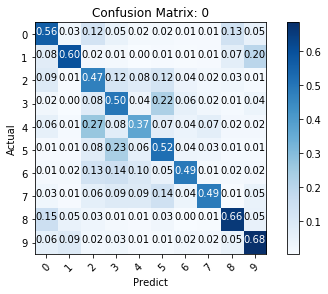

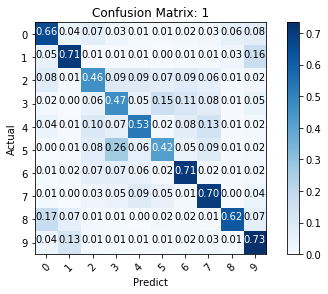

In [3]:
%matplotlib inline
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'

import torch.optim as optim

import torchbearer
from torchbearer import Trial
from torchbearer.callbacks import PyCM

cm = PyCM().on_val().to_pyplot(normalize=True, title='Confusion Matrix: {epoch}')

model = SimpleModel()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
loss = nn.CrossEntropyLoss()

trial = Trial(model, optimizer, loss, metrics=['acc', 'loss'], callbacks=[cm]).to(device)
trial.with_generators(train_generator=traingen, val_generator=valgen)
history = trial.run(epochs=2, verbose=1)

In the above code, we use string formatting to create a unique title for each confusion matrix and normalize the matrix. The available keys for formatting are anything in state, for the full list of keys, see [the docs](https://torchbearer.readthedocs.io/en/latest/code/main.html#key-list). The code used for the `to_pyplot` method is taken from the [`PyCM` documentation example 2](https://github.com/sepandhaghighi/pycm/tree/master/Document#example-2-how-to-plot-via-matplotlib).

## `to_file`

Suppose we want to save our PyCM object to a file for analysis later. We can do this with the various `to_XXX_file` type methods in the PyCM object. Each method is based on one of the available `save_XXX` methods from PyCM, which can be found [here](https://www.pycm.ir/doc/#Save). In this guide we'll have a look at two of the available methods, `to_obj_file` and `to_html_file`.

### `obj`

To save our matrices to `obj` files we again create a callback, this time just calling the `to_obj_file` method. We can again use string formatting here to save an individual file for each epoch.

In [4]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'

cm = PyCM().on_val().to_obj_file('cm.{epoch}')

model = SimpleModel()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
loss = nn.CrossEntropyLoss()

trial = Trial(model, optimizer, loss, metrics=['acc', 'loss'], callbacks=[cm]).to(device)
trial.with_generators(train_generator=traingen, val_generator=valgen)
history = trial.run(epochs=5, verbose=1)

We can then simply use the PyCM library to load in our confusion matrices.

In [5]:
from pycm import ConfusionMatrix, Compare

epoch_0 = ConfusionMatrix(file=open('cm.0.obj', 'r'))
epoch_1 = ConfusionMatrix(file=open('cm.1.obj', 'r'))
epoch_2 = ConfusionMatrix(file=open('cm.2.obj', 'r'))
epoch_3 = ConfusionMatrix(file=open('cm.3.obj', 'r'))
epoch_4 = ConfusionMatrix(file=open('cm.4.obj', 'r'))

print(Compare({"0": epoch_0, "1": epoch_1, "2": epoch_2, "3": epoch_3, "4": epoch_4}))

Best : 4

Rank     Name Class-Score     Overall-Score
1        4    30.95           4.48333
2        3    30.1            4.11667
3        2    29.8            3.86667
4        1    27.65           3.7
5        0    26.5            3.5



### `HTML`

To save to an `HTML` file we use the same approach as above.

In [6]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'

cm = PyCM().on_val().to_html_file('cm.{epoch}')

model = SimpleModel()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
loss = nn.CrossEntropyLoss()

trial = Trial(model, optimizer, loss, metrics=['acc', 'loss'], callbacks=[cm]).to(device)
trial.with_generators(train_generator=traingen, val_generator=valgen)
history = trial.run(epochs=5, verbose=1)

This time, to view our confusion matrix we need to open a web browser.

[Here's a link to open the confusion matrix from the last epoch](./cm.4.html)

**Note**: This may not work in Colab but you can always just download the file and open it on your own machine.

## Custom Handlers

Suppose we wish to follow some of the examples from the [PyCM docs](https://github.com/sepandhaghighi/pycm/tree/master/Document). We can do this with torchbearer by creating a custom handler. Let's have a look at how we can plot with `seaborn` and `pandas` using [example 7](https://github.com/sepandhaghighi/pycm/tree/master/Document#example-7-how-to-plot-via-seabornpandas).

We first install some dependencies.

In [7]:
try:
    import seaborn as sns
except:
    !pip install -q seaborn
    import seaborn as sns

try:
    from pandas import DataFrame
except:
    !pip install -q pandas
    from pandas import DataFrame

Next, we create our handler (a function of cm and state that does something with the confusion matrix) and a callback that will run it using the `with_handler` method.

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

def to_pandas_seaborn(normalize=False,title='Confusion matrix',annot=False,cmap="YlGnBu"):
    def handler(cm, state):
        plt.figure()
        string_state = {str(key): state[key] for key in state.keys()}  # For string formatting
        if normalize == True:
            df = DataFrame(cm.normalized_matrix).T.fillna(0)
        else:
            df = DataFrame(cm.matrix).T.fillna(0)
        ax = sns.heatmap(df,annot=annot,cmap=cmap)
        ax.set_title(title.format(**string_state))
        ax.set(xlabel='Predict', ylabel='Actual')
        plt.show()
    return handler

from torchbearer.callbacks import PyCM
cm = PyCM().on_val().with_handler(to_pandas_seaborn(normalize=True, title='Confusion Matrix: {epoch}'))

Now all that remains is to run a trial with our callback to see the output.

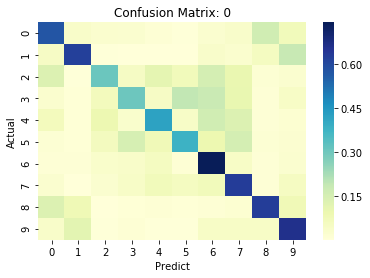

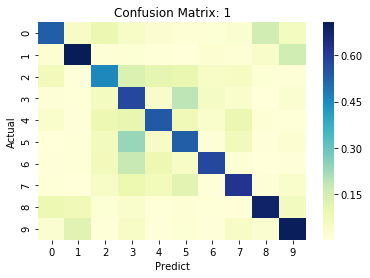

In [9]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'

import torch.optim as optim

import torchbearer
from torchbearer import Trial

model = SimpleModel()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
loss = nn.CrossEntropyLoss()

trial = Trial(model, optimizer, loss, metrics=['acc', 'loss'], callbacks=[cm]).to(device)
trial.with_generators(train_generator=traingen, val_generator=valgen)
history = trial.run(epochs=2, verbose=1)